In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install tensorflow


import tensorflow
print(tensorflow.__version__)
#!pip install tensorflow==1.15.3

2.18.0


In [ ]:
!pip install Pillow
!pip install scipy==1.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 54.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for scipy
  Running setup.py clean for scipy
  error: subprocess-exited-with-error
  
  × python setup.py clean did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed cleaning build dir for scipy
Failed to build scipy
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (scipy)


In [ ]:
! pip install SimpleITK
! pip install imageio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 11.3 MB/s eta 0:00:00


In [ ]:
import SimpleITK as sitk

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

##import SimpleITK as sitk

from PIL import Image

from imageio import imread

%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None

In [ ]:
annotations = pd.read_csv('/content/gdrive/My Drive/Dataset_LUNA_16/annotations.csv')
candidates = pd.read_csv('/content/gdrive/My Drive/Dataset_LUNA_16/candidates.csv')

In [ ]:
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [ ]:
candidates['class'].sum()

1351

In [ ]:
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551065 entries, 0 to 551064
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   seriesuid  551065 non-null  object 
 1   coordX     551065 non-null  float64
 2   coordY     551065 non-null  float64
 3   coordZ     551065 non-null  float64
 4   class      551065 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 21.0+ MB


In [ ]:
print(len(candidates[candidates['class'] == 1]))
print(len(candidates[candidates['class'] == 0]))

1351
549714


In [ ]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print(num_cores)

2


In [ ]:
class CTScan(object):
    def __init__(self, filename = None, coords = None):
        self.filename = filename
        self.coords = coords
        self.ds = None
        self.image = None

    def reset_coords(self, coords):
        self.coords = coords

    def read_mhd_image(self):
        path = glob.glob('/content/gdrive/My Drive/Dataset_LUNA_16/seg-lungs-LUNA16/*/'+ self.filename + '.mhd')
        self.ds = sitk.ReadImage(path[0])
        self.image = sitk.GetArrayFromImage(self.ds)

    def get_resolution(self):
        return self.ds.GetSpacing()

    def get_origin(self):
        return self.ds.GetOrigin()

    def get_ds(self):
        return self.ds

    def get_voxel_coords(self):
        origin = self.get_origin()
        resolution = self.get_resolution()
        voxel_coords = [np.absolute(self.coords[j]-origin[j])/resolution[j] \
            for j in range(len(self.coords))]
        return tuple(voxel_coords)

    def get_image(self):
        return self.image

    def get_subimage(self, width):
        self.read_mhd_image()
        x, y, z = self.get_voxel_coords()
        subImage = self.image[z, y-width/2:y+width/2, x-width/2:x+width/2]
        return subImage
    def normalizePlanes(self, npzarray):
        maxHU = 400.
        minHU = -1000.
        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray

    def save_image(self, filename, width):
        image = self.get_subimage(width)
        image = self.normalizePlanes(image)
        Image.fromarray(image*255).convert('L').save(filename)

In [ ]:
positives = candidates[candidates['class']==1].index
negatives = candidates[candidates['class']==0].index

In [ ]:
scan = CTScan(np.asarray(candidates.iloc[negatives[600]])[0], \
              np.asarray(candidates.iloc[negatives[600]])[1:-1])
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

In [ ]:
filename = '1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208'
coords = (70.19, -140.93, 877.68)#[877.68, -140.93, 70.19]
scan = CTScan(filename, coords)
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

In [ ]:
positives

Index([    13,     78,   1303,   3050,   3052,   3080,   3223,   3285,   3287,
         3289,
       ...
       545928, 546205, 546372, 546400, 547498, 548674, 550171, 550334, 550810,
       550906],
      dtype='int64', length=1351)

In [ ]:
np.random.seed(42)
negIndexes = np.random.choice(negatives, len(positives)*5, replace = False)

In [ ]:
candidatesDf = candidates.iloc[list(positives)+list(negIndexes)]

In [ ]:
from sklearn.model_selection import train_test_split
X = candidatesDf.iloc[:,:-1]
y = candidatesDf.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
X_train.size

25936

In [ ]:
y_train

,class
178085,0
108126,0
416697,0
342095,0
116478,0
...,...
469116,0
164439,0
333192,1
358382,0


In [ ]:
y_test

,class
189342,0
145102,0
31546,0
441280,1
215578,0
...,...
87015,0
245189,0
533231,0
52755,0


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

In [ ]:
X_train.size

20748

In [ ]:
X_train

,seriesuid,coordX,coordY,coordZ
59270,1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896...,-97.808167,3.897917,-201.030000
150277,1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929...,58.990000,-24.230000,-18.320000
432208,1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537...,-50.307219,159.439740,-113.418797
423122,1.3.6.1.4.1.14519.5.2.1.6279.6001.339882192295...,-106.731000,-104.468000,751.163333
344581,1.3.6.1.4.1.14519.5.2.1.6279.6001.296863826932...,67.240000,-32.590000,-107.790000
...,...,...,...,...
323102,1.3.6.1.4.1.14519.5.2.1.6279.6001.279953669991...,-22.239361,84.653132,-161.740390
94004,1.3.6.1.4.1.14519.5.2.1.6279.6001.149893110752...,52.320000,65.000000,-117.870000
459476,1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263...,-112.420630,37.648160,-67.928064
241550,1.3.6.1.4.1.14519.5.2.1.6279.6001.230416590143...,-27.740000,-121.660000,-254.130000


In [ ]:
y_train

,class
59270,0
150277,0
432208,0
423122,0
344581,0
...,...
323102,0
94004,0
459476,1
241550,0


In [ ]:
len(X_train)

5187

In [ ]:
X_train.to_pickle('/content/gdrive/My Drive/Dataset_LUNA_16/preprocessed_data/traindata')
X_test.to_pickle('/content/gdrive/My Drive/Dataset_LUNA_16/preprocessed_data/testdata')
X_val.to_pickle('/content/gdrive/My Drive/Dataset_LUNA_16/preprocessed_data/valdata')

PermissionError: [Errno 1] Operation not permitted: '/content/gdrive/My Drive/Dataset_LUNA_16/preprocessed_data/traindata'

In [ ]:
def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

In [ ]:
print('number of positive cases are ' + str(y_train.sum()))
print('total set size is ' + str(len(y_train)))
print('percentage of positive cases are ' + str(y_train.sum()*1.0/len(y_train)))

number of positive cases are 845
total set size is 5187
percentage of positive cases are 0.16290726817042606


In [ ]:


tempDf = X_train[y_train == 1]
tempDf = tempDf.set_index(X_train[y_train == 1].index + 1000000)

# Use pd.concat instead of append
X_train_new = pd.concat([X_train, tempDf])

tempDf = tempDf.set_index(X_train[y_train == 1].index + 2000000)

# Concatenate again
X_train_new = pd.concat([X_train_new, tempDf])

ytemp = y_train.reindex(X_train[y_train == 1].index + 1000000)
ytemp.loc[:] = 1
y_train_new = pd.concat([y_train, ytemp])

ytemp = y_train.reindex(X_train[y_train == 1].index + 2000000)
ytemp.loc[:] = 1
y_train_new = pd.concat([y_train_new, ytemp])

# Print the lengths of the new datasets
print(len(X_train_new), len(y_train_new))


6877 6877


In [ ]:
X_train_new

,seriesuid,coordX,coordY,coordZ
59270,1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896...,-97.808167,3.897917,-201.030000
150277,1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929...,58.990000,-24.230000,-18.320000
432208,1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537...,-50.307219,159.439740,-113.418797
423122,1.3.6.1.4.1.14519.5.2.1.6279.6001.339882192295...,-106.731000,-104.468000,751.163333
344581,1.3.6.1.4.1.14519.5.2.1.6279.6001.296863826932...,67.240000,-32.590000,-107.790000
...,...,...,...,...
2436163,1.3.6.1.4.1.14519.5.2.1.6279.6001.404768898286...,88.955096,224.250740,-586.901865
2013078,1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...,-57.089458,72.608061,1791.668825
2352132,1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547...,100.136716,3.904990,-93.909072
2188812,1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895...,118.180000,-42.910000,-247.440000


In [ ]:
y_train_new

,class
59270,0.0
150277,0.0
432208,0.0
423122,0.0
344581,0.0
...,...
2436163,1.0
2013078,1.0
2352132,1.0
2188812,1.0


In [ ]:
X_train_new.index

Index([  59270,  150277,  432208,  423122,  344581,   75111,  246217,  292479,
        147683,  468235,
       ...
       2282167, 2300642, 2021354, 2461166, 2332952, 2436163, 2013078, 2352132,
       2188812, 2459476],
      dtype='int64', length=6877)

In [ ]:
import scipy.misc

In [ ]:
import cv2

In [ ]:
#from scipy.misc import imresize
from PIL import ImageEnhance

class PreProcessing(object):
    def __init__(self, image = None):
        self.image = image

    def subtract_mean(self):
        self.image = (self.image/255.0 - 0.25)*255
        return self.image

    def downsample_data(self):
        self.image = cv2.resize(self.image, (40,40), interpolation = cv2.INTER_AREA)
        return self.image

    def upsample_data(self):
        self.image = cv2.resize(self.image, (224, 224), interpolation = cv2.INTER_CUBIC)
        return self.image

Imported the preprocessed and segmented dataset

<ipython-input-38-6c7d5fa238c5>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  inp = imread(dirName + 'image_'+ str(30517) + '.jpg')


Original shape of input image:  (50, 50)


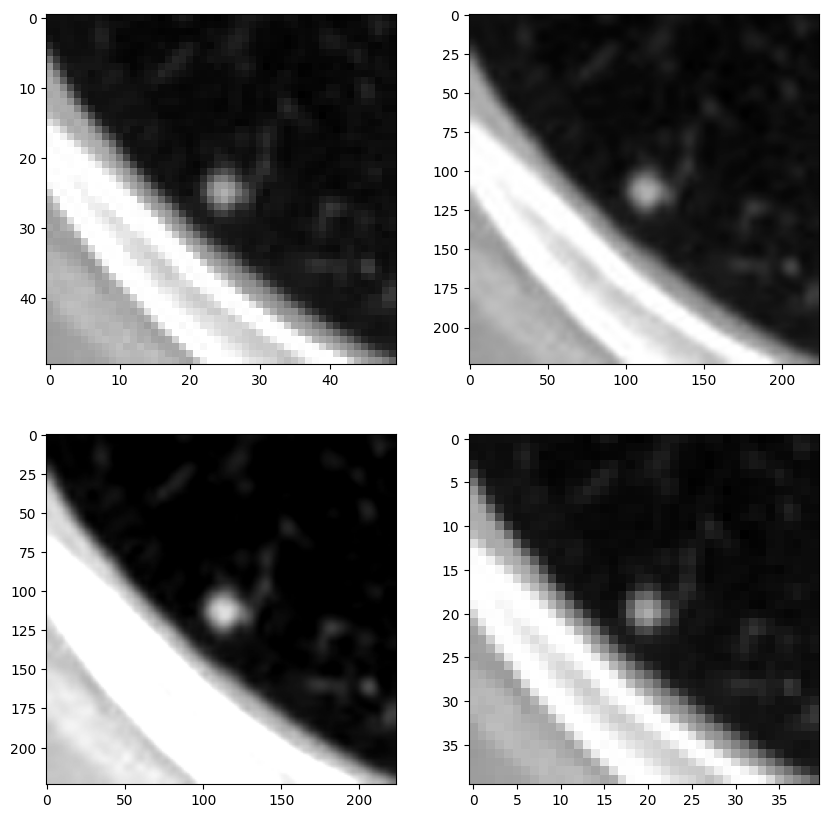

In [ ]:
dirName = '/content/gdrive/My Drive/Dataset_LUNA_16/data/train/'
plt.figure(figsize = (10,10))
inp = imread(dirName + 'image_'+ str(30517) + '.jpg')
print ("Original shape of input image: ", inp.shape)
plt.subplot(221)
plt.imshow(inp, cmap='gray')
plt.grid(False)

inp = PreProcessing(inp).upsample_data()
Pp = PreProcessing(inp)

inp2 = Pp.subtract_mean()
plt.subplot(222)
plt.imshow(inp2, cmap='gray')
plt.grid(False)

inp3 = ImageEnhance.Contrast(Image.fromarray(inp))
contrast = 1.5
inp3 = inp3.enhance(contrast)
plt.subplot(223)
plt.imshow(inp3, cmap='gray')
plt.grid(False)

inp4 = Pp.downsample_data()
plt.subplot(224)
plt.imshow(inp4,cmap='gray')
plt.grid(False)


In [ ]:
inp.shape

(224, 224)

In [ ]:
inp.dtype

dtype('uint8')

In [ ]:
#!pip install tflearn==0.3.2
#import tflearn

In [ ]:
y_train_new.values.astype(int)

array([0, 0, 0, ..., 1, 1, 1])

Training

In [ ]:
dirName

'/content/gdrive/My Drive/Dataset_LUNA_16/data/train/'

In [ ]:
train_filenames =\
X_train_new.index.to_series().apply(lambda x:\
                                    '/content/gdrive/My Drive/Dataset_LUNA_16/data/train/image_'+str(x)+'.jpg')
train_filenames.values.astype(str)

array(['/content/gdrive/My Drive/Dataset_LUNA_16/data/train/image_59270.jpg',
       '/content/gdrive/My Drive/Dataset_LUNA_16/data/train/image_150277.jpg',
       '/content/gdrive/My Drive/Dataset_LUNA_16/data/train/image_432208.jpg',
       ...,
       '/content/gdrive/My Drive/Dataset_LUNA_16/data/train/image_2352132.jpg',
       '/content/gdrive/My Drive/Dataset_LUNA_16/data/train/image_2188812.jpg',
       '/content/gdrive/My Drive/Dataset_LUNA_16/data/train/image_2459476.jpg'],
      dtype='<U69')

In [ ]:
train_filenames.values.astype(str)

array(['/content/gdrive/My Drive/Dataset_LUNA_16/data/train/image_59270.jpg',
       '/content/gdrive/My Drive/Dataset_LUNA_16/data/train/image_150277.jpg',
       '/content/gdrive/My Drive/Dataset_LUNA_16/data/train/image_432208.jpg',
       ...,
       '/content/gdrive/My Drive/Dataset_LUNA_16/data/train/image_2352132.jpg',
       '/content/gdrive/My Drive/Dataset_LUNA_16/data/train/image_2188812.jpg',
       '/content/gdrive/My Drive/Dataset_LUNA_16/data/train/image_2459476.jpg'],
      dtype='<U69')

In [ ]:
#@title Default title text
dataset_file = 'traindatalabels.txt'
filenames = train_filenames.values.astype(str)
train_filenames =X_train_new.index.to_series().apply(lambda x:filenames)
labels = y_train_new.values.astype(int)
traindata = np.zeros(filenames.size,\
                     dtype=[('var1', 'S36'), ('var2', int)])
traindata['var1'] = filenames
traindata['var2'] = labels

np.savetxt(dataset_file, traindata, fmt="%10s %d")

In [ ]:
traindata

array([(b'/content/gdrive/My Drive/Dataset_LUN', 0),
       (b'/content/gdrive/My Drive/Dataset_LUN', 0),
       (b'/content/gdrive/My Drive/Dataset_LUN', 0), ...,
       (b'/content/gdrive/My Drive/Dataset_LUN', 1),
       (b'/content/gdrive/My Drive/Dataset_LUN', 1),
       (b'/content/gdrive/My Drive/Dataset_LUN', 1)],
      dtype=[('var1', 'S36'), ('var2', '<i8')])

In [ ]:
#import tflearn

In [ ]:
# Build a HDF5 dataset (only required once)
#from tflearn.data_utils import build_hdf5_image_dataset
#build_hdf5_image_dataset(dataset_file, image_shape=(50, 50), mode='file', output_path='traindataset.h5', categorical_labels=True, normalize=True)

In [ ]:
# Load HDF5 dataset
import h5py
h5f = h5py.File('/content/gdrive/My Drive/Dataset_LUNA_16/data/traindataset.h5', 'r')
X_train_images = h5f['X']
Y_train_labels = h5f['Y']

h5f2 = h5py.File('/content/gdrive/My Drive/Dataset_LUNA_16/data/valdataset.h5', 'r')
X_val_images = h5f2['X']
Y_val_labels = h5f2['Y']

In [ ]:
X_train_images

<HDF5 dataset "X": shape (5187, 50, 50), type "<f4">

In [ ]:
Y_train_labels

<HDF5 dataset "Y": shape (5187, 2), type "<f4">

Testing_image_processing

In [ ]:
X_train_processing = np.array(X_train_images)
X_val_processing = np.array(X_val_images)

In [ ]:
print(X_train_processing.shape)
print(X_val_processing.shape)

(5187, 50, 50)
(1297, 50, 50)


In [ ]:
print(X_train_processing.dtype)
print(X_val_processing.dtype)

float32
float32


In [ ]:
img_test = X_train_processing[1000]
img_test_downsampled = PreProcessing(img_test).downsample_data()
img_test_upsampled = PreProcessing(img_test).upsample_data()

In [ ]:
print(Y_train_labels[1000])

[1. 0.]


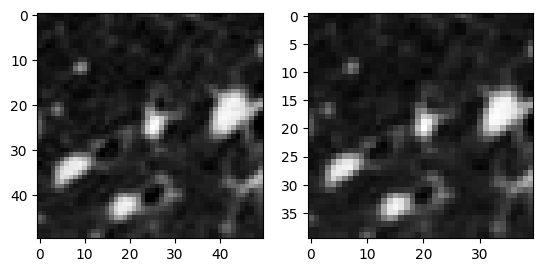

In [ ]:
plt.subplot(121)
plt.imshow(img_test,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_downsampled,cmap='gray')

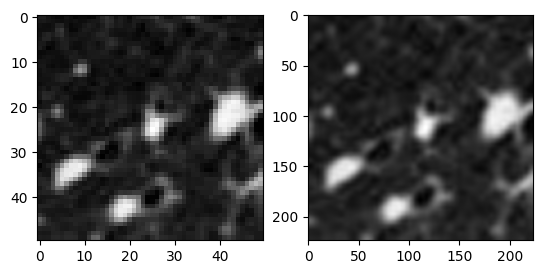

In [ ]:
plt.subplot(121)
plt.imshow(img_test,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_upsampled,cmap='gray')

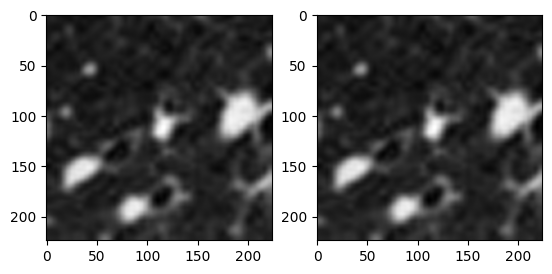

In [ ]:
img_test_subtracted_mean = PreProcessing(img_test_upsampled).subtract_mean()
plt.subplot(121)
plt.imshow(img_test_upsampled,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_subtracted_mean,cmap='gray')

testing cv2 BRISK algorithm

need some work and research

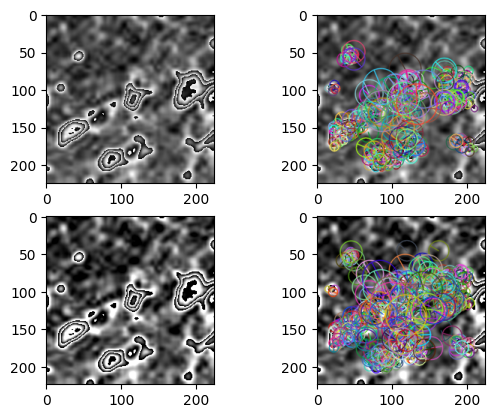

In [ ]:
import cv2
brisk = cv2.BRISK_create(50)
img_BRISK_1 = img_test_upsampled.copy()
rgb = cv2.cvtColor(img_BRISK_1, cv2.COLOR_GRAY2RGB)
img_BRISK_2 = rgb*1000
img_BRISK_3 = np.array(img_BRISK_2, dtype=np.uint8)
img_contr_copy = img_BRISK_3.copy()

plt.subplot(221)
plt.imshow(img_BRISK_3, cmap='gray')
kpts_1, des_1 = brisk.detectAndCompute(img_BRISK_3, None)

image_BRISK_1 = cv2.drawKeypoints(image=img_BRISK_3, outImage=img_BRISK_3, keypoints=kpts_1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.subplot(222)
plt.imshow(image_BRISK_1, cmap='gray')


# with enhanced contrast

inp_contr = ImageEnhance.Contrast(Image.fromarray(img_contr_copy))
contrast = 1.5
img_contr = inp_contr.enhance(contrast)
plt.subplot(223)
plt.imshow(img_contr, cmap='gray')
img_BRISK_4 = np.array(img_contr)
kpts_2, des_2 = brisk.detectAndCompute(img_BRISK_4, None)

image_BRISK_2 = cv2.drawKeypoints(image=img_BRISK_4, outImage=img_BRISK_4, keypoints=kpts_2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.subplot(224)
plt.imshow(image_BRISK_2, cmap='gray')

test both with other CV2 algorithms and then implement all those algorithms with DL model self defined.

Converting to training dataset

In [ ]:
X_train_images_np = np.expand_dims(np.array(X_train_images), axis = 3)
y_train_labels_np = np.array(Y_train_labels)
X_val_images_np = np.expand_dims(np.array(X_val_images), axis = 3)
y_val_labels_np = np.array(Y_val_labels)

In [ ]:
print(X_train_images_np.shape)
print(y_train_labels_np.shape)
print(X_val_images_np.shape)
print(y_val_labels_np.shape)

(5187, 50, 50, 1)
(5187, 2)
(1297, 50, 50, 1)
(1297, 2)


In [ ]:
print(X_train_images_np.dtype)
print(y_train_labels_np.dtype)
print(X_val_images_np.dtype)
print(y_val_labels_np.dtype)

float32
float32
float32
float32


processing for test dataset

In [ ]:
h5f2 = h5py.File('/content/gdrive/My Drive/Dataset_LUNA_16/data/testdataset.h5', 'r')
X_test_images = h5f2['X']
Y_test_labels = h5f2['Y']

In [ ]:
X_test_images_np = np.expand_dims(np.array(X_test_images), axis = 3)
y_test_labels_np = np.array(Y_test_labels)

In [ ]:
print(X_test_images_np.shape)
print(y_test_labels_np.shape)

(1622, 50, 50, 1)
(1622, 2)


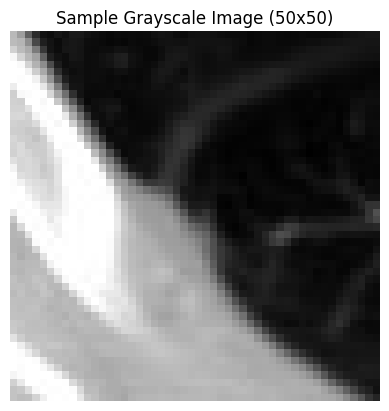

In [ ]:
plt.imshow(X_train_images_np[5], cmap='gray')
plt.title("Sample Grayscale Image (50x50)")
plt.axis('off')  # Hide axis for better visualization
plt.show()


In [ ]:
print(X_test_images_np.dtype)
print(y_test_labels_np.dtype)

float32
float32


Model Making and Model Training

In [ ]:

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,AveragePooling2D
from keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras.optimizers import Adam
from keras.models import Model

In [ ]:
from tensorflow.keras import layers, Model

def define_model():
    inputs = layers.Input(shape=(50, 50, 1))  # Input layer

    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.5)(x)

    # Add Multi-Head Attention Layer
    # Note: Attention layers generally require sequences, so you will need to reshape your feature maps into a sequence-like shape
    x = layers.Reshape((-1, 128))(x)  # Flatten spatial dimensions, leaving the channel dimension as is
    x = layers.MultiHeadAttention(num_heads=2, key_dim=16)(x, x)  # Multi-head attention

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=x)
    return model

mobile = define_model()


model based on deep cnn

In [ ]:

mobile.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 50, 50, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 50, 50, 32)     │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 50, 50, 32)     │            128 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 50, 50, 32)     │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 50, 50, 32)     │            128 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 25, 25, 32)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 25, 25, 32)     │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 25, 25, 64)     │         18,496 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 25, 25, 64)     │            256 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 25, 25, 64)     │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 25, 25, 64)     │            256 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 12, 12, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 12, 12, 64)     │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 12, 12, 128)    │         73,856 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 12, 12, 128)    │            512 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)   

 Total params: 930,752 (3.55 MB)

 Trainable params: 928,576 (3.54 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [ ]:
op_layer = mobile.output  # Output of the `mobile` model

# Add custom dense layers
final_layer = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(op_layer)
final_layer = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(final_layer)
final_layer = layers.Dense(2, activation='softmax')(final_layer)

# Define the final model using the Functional API
model = Model(inputs=mobile.input, outputs=final_layer)

# Compile the model
optimizer_sgd = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer_sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 50, 50, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 50, 50, 32)     │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 50, 50, 32)     │            128 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 50, 50, 32)     │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 50, 50, 32)     │            128 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 25, 25, 32)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 25, 25, 32)     │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 25, 25, 64)     │         18,496 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 25, 25, 64)     │            256 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 25, 25, 64)     │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 25, 25, 64)     │            256 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 12, 12, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 12, 12, 64)     │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 12, 12, 128)    │         73,856 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 12, 12, 128)    │            512 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)   

 Total params: 964,034 (3.68 MB)

 Trainable params: 961,858 (3.67 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [ ]:

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 50, 50, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 50, 50, 32)     │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 50, 50, 32)     │            128 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 50, 50, 32)     │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 50, 50, 32)     │            128 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 25, 25, 32)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 25, 25, 32)     │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 25, 25, 64)     │         18,496 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 25, 25, 64)     │            256 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 25, 25, 64)     │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 25, 25, 64)     │            256 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 12, 12, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 12, 12, 64)     │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 12, 12, 128)    │         73,856 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 12, 12, 128)    │            512 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)   

 Total params: 964,034 (3.68 MB)

 Trainable params: 961,858 (3.67 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [ ]:
import matplotlib.pyplot as plt

# Define a function to plot diagnostic learning curves
def summarize_diagnostics(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# Example usage:
# Assuming `history` is the output from model.fit()
# summarize_diagnostics(history)


In [ ]:
import tensorflow as tf
from tensorflow.keras import callbacks

# Define the callbacks
callbacks = [
    callbacks.ModelCheckpoint('classification_deep_conv_model.keras', save_best_only=True),
    callbacks.ReduceLROnPlateau()
]


In [ ]:
X_train_images_np.shape




(5187, 50, 50, 1)

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 205ms/step - accuracy: 0.8088 - loss: 0.5509 - val_accuracy: 0.8234 - val_loss: 0.5615 - learning_rate: 0.0010
Epoch 2/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8212 - loss: 0.4752 - val_accuracy: 0.8273 - val_loss: 0.4760 - learning_rate: 0.0010
Epoch 3/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8359 - loss: 0.4274 - val_accuracy: 0.8327 - val_loss: 0.4195 - learning_rate: 0.0010
Epoch 4/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8285 - loss: 0.4193 - val_accuracy: 0.8381 - val_loss: 0.3643 - learning_rate: 0.0010
Epoch 5/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8478 - loss: 0.3645 - val_accuracy: 0.8743 - val_loss: 0.3168 - learning_rate: 0.0010
Epoch 6/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8464 - loss: 0.3613 - val_accuracy: 0.8712 - val_loss: 0.3240 - learning_rate: 0.0010
Epoch 7/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8615 - loss: 0.3315 - val_accura

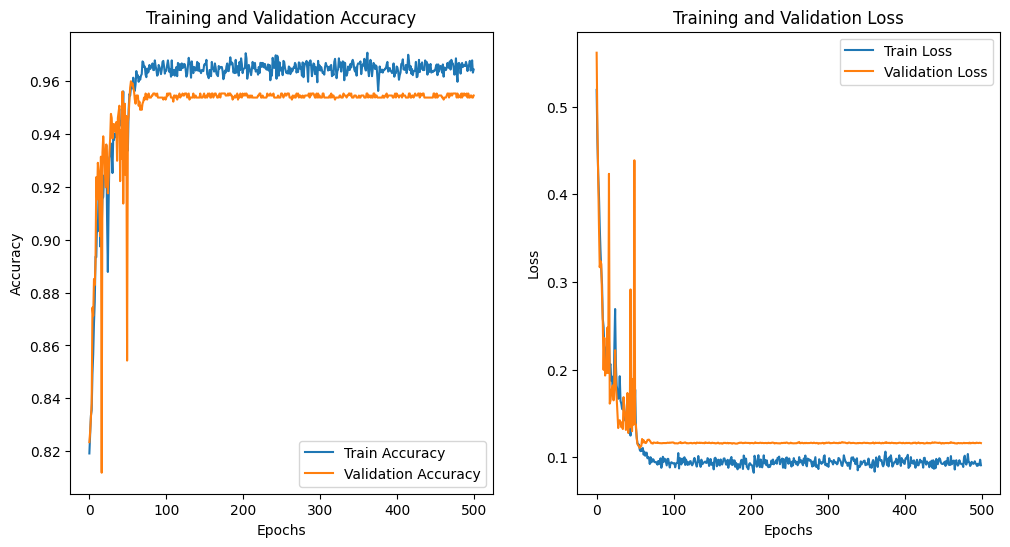

In [ ]:
# run the test harness for evaluating a model
def run_test_harness():
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,zoom_range=0.1)
	# prepare iterator
	it_train = datagen.flow(X_train_images_np, y_train_labels_np, batch_size=64)
	# fit model
	steps = np.ceil(X_train_images_np.shape[0] / 64).astype(int)

	hist = model.fit(it_train, steps_per_epoch=steps, epochs=500, validation_data=(X_val_images_np, y_val_labels_np), verbose=1, callbacks = callbacks)
	# evaluate model
	_, acc = model.evaluate(X_val_images_np, y_val_labels_np, verbose=1)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(hist)

# entry point, run the test harness
run_test_harness()


In [80]:


import tensorflow as tf
from tensorflow import keras

# Load the model with `safe_mode=False`
model_new_1 = keras.models.load_model("classification_deep_conv_model.keras", safe_mode=False)


In [81]:
model_new_1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 50, 50, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 50, 50, 32)     │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 50, 50, 32)     │            128 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 50, 50, 32)     │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 50, 50, 32)     │            128 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 25, 25, 32)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 25, 25, 32)     │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 25, 25, 64)     │         18,496 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 25, 25, 64)     │            256 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 25, 25, 64)     │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 25, 25, 64)     │            256 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 12, 12, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 12, 12, 64)     │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 12, 12, 128)    │         73,856 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 12, 12, 128)    │            512 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)   

 Total params: 2,887,752 (11.02 MB)

 Trainable params: 961,858 (3.67 MB)

 Non-trainable params: 2,176 (8.50 KB)

 Optimizer params: 1,923,718 (7.34 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step
Confusion Matrix:
[[1298   42]
 [  34  248]]


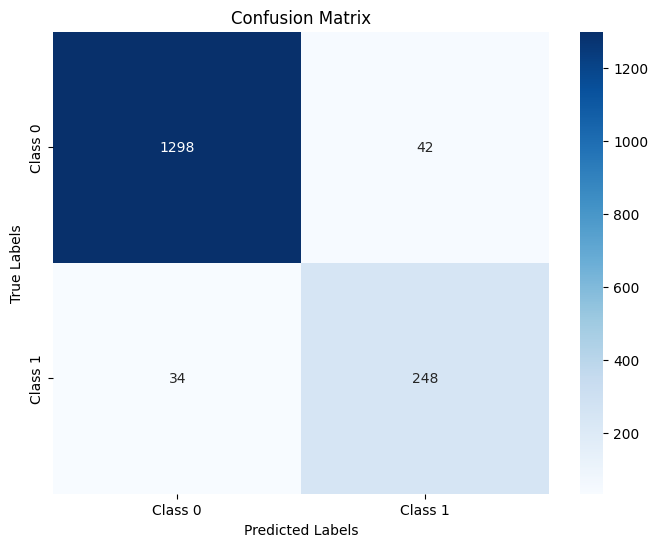

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1340
           1       0.86      0.88      0.87       282

    accuracy                           0.95      1622
   macro avg       0.91      0.92      0.92      1622
weighted avg       0.95      0.95      0.95      1622



In [82]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predicting the labels
y_pred = model.predict(X_test_images_np)
y_p = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_labels_np, axis=1)

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_p)
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["Class 0(Non-Cancerous)", "Class "], yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
report = classification_report(y_true, y_p)
print("Classification Report:")
print(report)


In [83]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1340
           1       0.86      0.88      0.87       282

    accuracy                           0.95      1622
   macro avg       0.91      0.92      0.92      1622
weighted avg       0.95      0.95      0.95      1622



In [86]:
X_test_images_np[0].shape

(50, 50, 1)

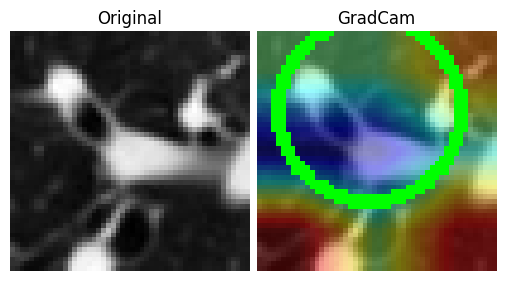

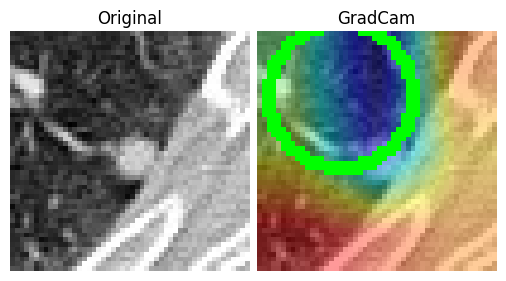

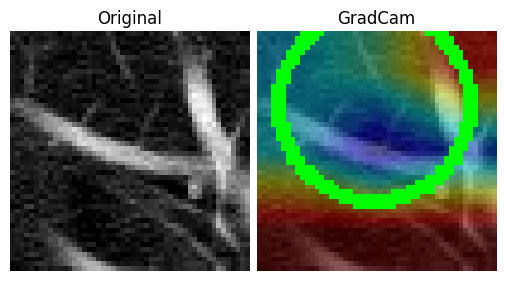

In [119]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import random

# Function to generate Grad-CAM heatmap
def get_grad_cam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations and predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        # Forward pass
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # Predicted class index
        class_channel = predictions[:, pred_index]

    # Compute gradients of the predicted class w.r.t. last conv layer output
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the output feature map by the gradients
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)

    # Normalize heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Function to overlay heatmap on original image
def overlay_heatmap_on_image(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    # Ensure the original image is in RGB format
    if len(img.shape) == 2 or img.shape[-1] == 1:  # Grayscale image
        img = cv2.cvtColor(img.squeeze(), cv2.COLOR_GRAY2RGB)

    # Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)

    # Overlay heatmap on original image
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

# Function to draw circles around high-intensity regions in the heatmap
# Function to draw circles around high-intensity regions in the heatmap
def draw_circles_on_heatmap(img, heatmap, threshold=0.5, radius_scale=0.7):
    # Find coordinates where heatmap intensity exceeds threshold
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Resize heatmap
    heatmap = np.uint8(255 * heatmap)  # Normalize to 0-255 range
    _, binary_map = cv2.threshold(heatmap, threshold * 255, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw circles around the contours (high-intensity areas)
    for contour in contours:
        # Get the center and radius of the circle
        if cv2.contourArea(contour) > 100:  # Ignore small areas
            (x, y), radius = cv2.minEnclosingCircle(contour)
            radius = radius * radius_scale  # Scale down the radius to make the circle smaller
            img = cv2.circle(img, (int(x), int(y)), int(radius), (0, 255, 0), 2)  # Draw circle in green

    return img


# Randomly select 3 images from test dataset
num_images = 3
last_conv_layer_name = 'conv2d_19'  # Replace with your model's last Conv2D layer
random_indices= [1412, 1225, 1470]

for i, idx in enumerate(random_indices):
    # Original test image
    original_img = X_test_images_np[idx]  # Shape: (50, 50, 1)
    img_array = np.expand_dims(original_img, axis=0)  # Add batch dimension

    # Generate Grad-CAM heatmap
    heatmap = get_grad_cam_heatmap(model, img_array, last_conv_layer_name)

    # Overlay heatmap on original image
    original_img = (original_img * 255).astype(np.uint8)  # Convert to 0-255 range
    heatmap_img = overlay_heatmap_on_image(original_img, heatmap)

    # Draw circles around high-importance areas
    img_with_circles = draw_circles_on_heatmap(heatmap_img.copy(), heatmap, threshold=0.5)

    # Plot the results
    plt.figure(figsize=(5, 5))  # Keep small figure size to match 50x50 pixels

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img.squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Grad-CAM Heatmap Image with circles
    plt.subplot(1, 2, 2)
    plt.imshow(img_with_circles)
    plt.title("GradCam")
    plt.axis('off')

    plt.tight_layout(pad=0.5)  # Adjust padding between plots
    plt.show()


In [111]:
print(random_indices)

[1412, 1499, 1470]


In [ ]:
1412,318